UNet and M2NIST
===============

[Multidigit MNIST(M2NIST)](https://www.kaggle.com/datasets/farhanhubble/multimnistm2nist)

#### Context

I created this dataset to teach the basics of fully convolution networks for semantic segmentation of images. Most real-world semantic image segmentation tasks require building huge networks that are slow to train and experiment with. The dataset was generated by selecting up to 3 random 28px x 28px grayscale images from the MNIST dataset and copying them in to a single 64px(height) x 84px(width) image. The digits were pasted so that they did not overlap and no transformations were applied to the original images, so digits in M2NIST maintain the same orientation as the have in MNIST.
Content

#### Content

The dataset has 5000 multi-digit images in combined.npy and 11 segmentation masks for every image in segmented.npy. The files can be read in using `numpy.load()`, for example, as `combined=np.load('combined.npy')` and `segmented = np.load('segmented.npy')`. The data in `combined.npy` has shape `(5000, 64, 84)` while the data in `segmented.npy` has shape `(5000, 64, 84, 11)`. Every element in combined.npy is a grayscale image with up to 3 digits. The corresponding element in segmented.npy is a tensor with 64 rows, 84 columns and 11 layers or channels. Each layer or channel is a binary mask. The k-th layer (0<=k<9) has 1s wherever the digit k is present in the combined image and 0s everywhere else. The last layer `k=10` represents background and has 1s wherever there is no digit in the combined image and 0's wherever at pixels where some digit is present in the original image.
Acknowledgements

In [1]:
import random
import itertools
import time
import copy

from functools import reduce
from collections import defaultdict

from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import relu
from torch.nn import Sequential
from torch.nn import Conv2d, Dropout2d, MaxPool2d, ReLU, UpsamplingNearest2d
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, datasets
from torchvision import ops

from torchsummary import summary

#  UNet

## UNet

### Naive

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last baseline block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        self.e11 = nn.Conv2d(1, 32, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = nn.Conv2d(32, 32, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512


        # Baseline
        # input: 32x32x512
        self.e51 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 28x28x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(32, 32, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(32, n_class, kernel_size=1)


    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
unet_model_str = UNet(10).to(device)
summary(unet_model_str, input_size=(1, 64, 64))       

### Tunable

In [15]:
class UNetTune(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetTune, self).__init__()
        
        def conv_block(in_ch, out_ch):
            return nn.Sequential(nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                                 nn.BatchNorm2d(out_ch),
                                 nn.ReLU(inplace=True),
                                 nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                                 nn.BatchNorm2d(out_ch),
                                 nn.ReLU(inplace=True))
        
        self.encoder1 = conv_block(in_channels, 32)
        self.encoder2 = conv_block(32, 64)
        self.encoder3 = conv_block(64, 128)
        self.encoder4 = conv_block(128, 256)
        
        self.pool = nn.MaxPool2d(2)
        
        self.baseline1 = conv_block(256, 512)
        self.baseline2 = conv_block(512, 512)
        
        self.upconv4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder4 = conv_block(512, 256)
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder3 = conv_block(256, 128)
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder2 = conv_block(128, 64)
        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.decoder1 = conv_block(64, 32)
        
        self.out_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder path
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))
        
        # Middle path
        base1 = self.baseline1(self.pool(enc4))
        base2 = self.baseline2(base1)
        
        # Decoder path
        dec4 = torch.cat((self.upconv4(base2), enc4), dim=1)
        dec4 = self.decoder4(dec4)
        
        dec3 = torch.cat((self.upconv3(dec4), enc3), dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = torch.cat((self.upconv2(dec3), enc2), dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = torch.cat((self.upconv1(dec2), enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        out = self.out_conv(dec1)
        return out
    

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
unet_model_str = UNetTune(1, 10).to(device)
summary(unet_model_str, input_size=(1, 64, 64))    

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           9,248
       BatchNorm2d-5           [-1, 32, 64, 64]              64
              ReLU-6           [-1, 32, 64, 64]               0
         MaxPool2d-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          18,496
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,928
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
        MaxPool2d-14           [-1, 64,

## UNetMini

### Naive

In [16]:
class UNetMini(nn.Module):

    def __init__(self, num_classes):
        super(UNetMini, self).__init__()

        # Use padding 1 to mimic `padding='same'` in keras,
        # use this visualization tool https://ezyang.github.io/convolution-visualizer/index.html
        self.block1 = Sequential(
            Conv2d(1, 32, kernel_size=3, padding=1),
            ReLU(),
            Dropout2d(0.2),
            Conv2d(32, 32, kernel_size=3, padding=1),
            ReLU(),
        )
        self.pool1 = MaxPool2d((2, 2))

        self.block2 = Sequential(
            Conv2d(32, 64, kernel_size=3, padding=1),
            ReLU(),
            Dropout2d(0.2),
            Conv2d(64, 64, kernel_size=3, padding=1),
            ReLU(),
        )
        self.pool2 = MaxPool2d((2, 2))

        self.block3 = Sequential(
            Conv2d(64, 128, kernel_size=3, padding=1),
            ReLU(),
            Dropout2d(0.2),
            Conv2d(128, 128, kernel_size=3, padding=1),
            ReLU()
        )

        self.up1 = UpsamplingNearest2d(scale_factor=2)
        self.block4 = Sequential(
            Conv2d(192, 64, kernel_size=3, padding=1),
            ReLU(),
            Dropout2d(0.2),
            Conv2d(64, 64, kernel_size=3, padding=1),
            ReLU()
        )

        self.up2 = UpsamplingNearest2d(scale_factor=2)
        self.block5 = Sequential(
            Conv2d(96, 32, kernel_size=3, padding=1),
            ReLU(),
            Dropout2d(0.2),
            Conv2d(32, 32, kernel_size=3, padding=1),
            ReLU()
        )

        self.conv2d = Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x):
        out1 = self.block1(x)
        out_pool1 = self.pool1(out1)

        out2 = self.block2(out_pool1)
        out_pool2 = self.pool1(out2)

        out3 = self.block3(out_pool2)

        out_up1 = self.up1(out3)
        # return out_up1
        out4 = torch.cat((out_up1, out2), dim=1)
        out4 = self.block4(out4)

        out_up2 = self.up2(out4)
        out5 = torch.cat((out_up2, out1), dim=1)
        out5 = self.block5(out5)

        out = self.conv2d(out5)

        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
unetmini_model_str = UNetMini(10).to(device)
summary(unetmini_model_str, input_size=(1, 64, 84))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 84]             320
              ReLU-2           [-1, 32, 64, 84]               0
         Dropout2d-3           [-1, 32, 64, 84]               0
            Conv2d-4           [-1, 32, 64, 84]           9,248
              ReLU-5           [-1, 32, 64, 84]               0
         MaxPool2d-6           [-1, 32, 32, 42]               0
            Conv2d-7           [-1, 64, 32, 42]          18,496
              ReLU-8           [-1, 64, 32, 42]               0
         Dropout2d-9           [-1, 64, 32, 42]               0
           Conv2d-10           [-1, 64, 32, 42]          36,928
             ReLU-11           [-1, 64, 32, 42]               0
        MaxPool2d-12           [-1, 64, 16, 21]               0
           Conv2d-13          [-1, 128, 16, 21]          73,856
             ReLU-14          [-1, 128,

### Tunable

In [19]:
class UNetMiniTune(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetMiniTune, self).__init__()
        
        def conv_block(in_ch, out_ch):
            return nn.Sequential(nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                                 nn.BatchNorm2d(out_ch),
                                 nn.ReLU(inplace=True),
                                 nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                                 nn.BatchNorm2d(out_ch),
                                 nn.ReLU(inplace=True))
        
        self.encoder1 = conv_block(in_channels, 32)
        self.encoder2 = conv_block(32, 64)
        
        self.pool = nn.MaxPool2d(2)
        
        self.baseline1 = conv_block(64, 128)
        
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder2 = conv_block(128, 64)
        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.decoder1 = conv_block(64, 32)
        
        self.out_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder path
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        
        # Middle path
        base1 = self.baseline1(self.pool(enc2))
        
        # Decoder path
        dec2 = torch.cat((self.upconv2(base1), enc2), dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = torch.cat((self.upconv1(dec2), enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        out = self.out_conv(dec1)
        return out
    

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
unet_model_str = UNetMiniTune(1, 10).to(device)
summary(unet_model_str, input_size=(1, 64, 64))    

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           9,248
       BatchNorm2d-5           [-1, 32, 64, 64]              64
              ReLU-6           [-1, 32, 64, 64]               0
         MaxPool2d-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          18,496
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,928
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
        MaxPool2d-14           [-1, 64,

# Data

### M2NIST

In [11]:
combined = np.load('data/M2NIST/combined.npy')
segmented = np.load('data/M2NIST/segmented.npy')  # [:,:,:,:10]

print(combined.shape)
print(segmented.shape)


class M2NISTData(Dataset):
    def __init__(self, combined, segmented, samp_size=100, samp_type='trn', transform=None):
        self.transform = transform
        if samp_type == 'trn':    
            self.combined = combined[:samp_size]
            self.segmented = segmented[:samp_size]
        elif samp_type == 'val':
            self.combined = combined[-samp_size:]
            self.segmented = segmented[-samp_size:]

    def __len__(self):
        return (len(self.combined))

    def __getitem__(self, idx):
        image = self.combined[idx,:,:64].astype(np.uint8)  # np.stack((image, np.zeros_like(image), np.zeros_like(image)), axis=-1)  # pseudo RGB
        label = np.moveaxis(self.segmented[idx,:,:64,:], -1, 0).astype(np.float32)
        
        if self.transform:
            image = self.transform(image)
        else:
            image = torch.unsqueeze(image, 0)
        
        return image, label

def get_dataloaders(combined_data, segmented_data, train_samp_size=500, val_samp_size=50, batch_size=10):
    trans = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.], std=[1.])])
    
    train_dataset = M2NISTData(combined=combined_data, segmented=segmented_data,
                               samp_size=train_samp_size, samp_type='trn', transform=trans)
    val_dataset = M2NISTData(combined=combined_data, segmented=segmented_data,
                             samp_size=val_samp_size, samp_type='val', transform=trans)

    trn_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

    return trn_loader, val_loader

(5000, 64, 84)
(5000, 64, 84, 11)


<class 'torch.Tensor'>
<class 'numpy.ndarray'>
torch.Size([1, 64, 64]) (11, 64, 64)


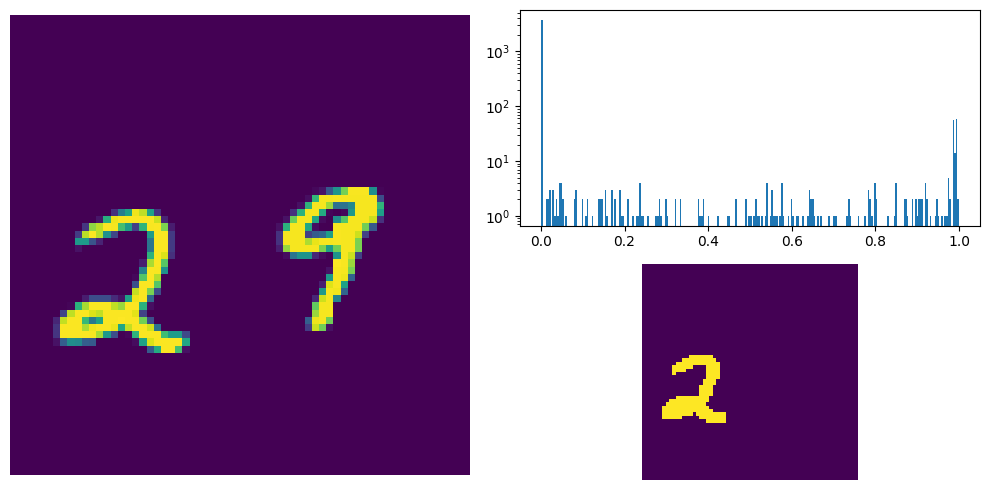

In [12]:
demo_trans = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0], std=[1])])

demo_dataset = M2NISTData(combined=combined, segmented=segmented,
                          samp_size=20, samp_type='val', transform=demo_trans)

img, lab = demo_dataset.__getitem__(2)

print(type(img))
print(type(lab))
print(img.shape, lab.shape)

plt.figure(figsize=(10,5))
plt.subplot(2,2,(1,3))
plt.imshow(img[0])
plt.axis('off')

plt.subplot(2,2,2)
plt.hist(img.ravel(), bins=256)
plt.yscale('log')

plt.subplot(2,2,4)
plt.imshow(lab[2,...])
plt.axis('off')

plt.tight_layout()
plt.show()

### Symbols

#### Generator

In [ ]:
def generate_random_data(height, width, zoom, count):
    x, y = zip(*[generate_img_and_mask(height, width, zoom) for i in range(0, count)])

    X = np.array(x) * 255
    X = X[:,0,:,:].astype(np.uint8)
    Y = np.array(y)

    return X, Y


def generate_img_and_mask(height, width, zoom):
    shape = (height, width)

    # triangle_location = get_random_location(*shape)
    # circle_location1 = get_random_location(*shape, zoom=zoom)
    circle_location2 = get_random_location(*shape, zoom=zoom)
    # mesh_location = get_random_location(*shape)
    # square_location = get_random_location(*shape, zoom=0.8)
    plus_location = get_random_location(*shape, zoom=zoom)

    # Create input image
    arr = np.zeros(shape, dtype=bool)
    # arr = add_triangle(arr, *triangle_location)
    # arr = add_circle(arr, *circle_location1)
    arr = add_circle(arr, *circle_location2, fill=True)
    # arr = add_mesh_square(arr, *mesh_location)
    # arr = add_filled_square(arr, *square_location)
    arr = add_plus(arr, *plus_location)
    arr = np.reshape(arr, (1, height, width)).astype(np.float32)

    # Create target masks
    masks = np.asarray([
        # add_filled_square(np.zeros(shape, dtype=bool), *square_location),
        add_circle(np.zeros(shape, dtype=bool), *circle_location2, fill=True),
        # add_triangle(np.zeros(shape, dtype=bool), *triangle_location),
        # add_circle(np.zeros(shape, dtype=bool), *circle_location1),
        #  add_filled_square(np.zeros(shape, dtype=bool), *mesh_location),
        # add_mesh_square(np.zeros(shape, dtype=bool), *mesh_location),
        add_plus(np.zeros(shape, dtype=bool), *plus_location)
    ]).astype(np.float32)

    return arr, masks


def add_square(arr, x, y, size):
    s = int(size / 2)
    arr[x-s,y-s:y+s] = True
    arr[x+s,y-s:y+s] = True
    arr[x-s:x+s,y-s] = True
    arr[x-s:x+s,y+s] = True

    return arr


def add_filled_square(arr, x, y, size):
    s = int(size / 2)

    xx, yy = np.mgrid[:arr.shape[0], :arr.shape[1]]

    return np.logical_or(arr, logical_and([xx > x - s, xx < x + s, yy > y - s, yy < y + s]))


def logical_and(arrays):
    new_array = np.ones(arrays[0].shape, dtype=bool)
    for a in arrays:
        new_array = np.logical_and(new_array, a)

    return new_array


def add_mesh_square(arr, x, y, size):
    s = int(size / 2)

    xx, yy = np.mgrid[:arr.shape[0], :arr.shape[1]]

    return np.logical_or(arr, logical_and([xx > x - s, xx < x + s, xx % 2 == 1, yy > y - s, yy < y + s, yy % 2 == 1]))


def add_triangle(arr, x, y, size):
    s = int(size / 2)

    triangle = np.tril(np.ones((size, size), dtype=bool))

    arr[x-s:x-s+triangle.shape[0],y-s:y-s+triangle.shape[1]] = triangle

    return arr


def add_circle(arr, x, y, size, fill=False):
    xx, yy = np.mgrid[:arr.shape[0], :arr.shape[1]]
    circle = np.sqrt((xx - x) ** 2 + (yy - y) ** 2)
    new_arr = np.logical_or(arr, np.logical_and(circle < size, circle >= size * 0.7 if not fill else True))

    return new_arr


def add_plus(arr, x, y, size):
    s = int(size / 2)
    arr[x-1:x+1,y-s:y+s] = True
    arr[x-s:x+s,y-1:y+1] = True

    return arr


def get_random_location(width, height, zoom=1.0):
    x = int(width * random.uniform(0.1, 0.9))
    y = int(height * random.uniform(0.1, 0.9))

    size = int(min(width, height) * random.uniform(0.1, 0.2) * zoom)

    return (x, y, size)


def plot_img_array(img_array, ncol=3):
    nrow = len(img_array) // ncol

    f, plots = plt.subplots(nrow, ncol, sharex='all', sharey='all', figsize=(ncol * 4, nrow * 4))

    for i in range(len(img_array)):
        plots[i // ncol, i % ncol]
        plots[i // ncol, i % ncol].imshow(img_array[i])


def plot_side_by_side(img_arrays):
    flatten_list = reduce(lambda x,y: x+y, zip(*img_arrays))

    plot_img_array(np.array(flatten_list), ncol=len(img_arrays))


def plot_errors(results_dict, title):
    markers = itertools.cycle(('+', 'x', 'o'))

    plt.title('{}'.format(title))

    for label, result in sorted(results_dict.items()):
        plt.plot(result, marker=next(markers), label=label)
        plt.ylabel('dice_coef')
        plt.xlabel('epoch')
        plt.legend(loc=3, bbox_to_anchor=(1, 0))

    plt.show()


def masks_to_colorimg(masks):
    colors = np.asarray([(201, 58, 64), (242, 207, 1), (0, 152, 75), (101, 172, 228),(56, 34, 132), (160, 194, 56)])

    colorimg = np.ones((masks.shape[1], masks.shape[2], 3), dtype=np.float32) * 255
    channels, height, width = masks.shape

    for y in range(height):
        for x in range(width):
            selected_colors = colors[masks[:,y,x] > 0.5]

            if len(selected_colors) > 0:
                colorimg[y,x,:] = np.mean(selected_colors, axis=0)

    return colorimg.astype(np.uint8)


def generate_images_and_masks_then_plot():
    # Generate some random images
    input_images, target_masks = generate_random_data(192, 192, count=3)

    for x in [input_images, target_masks]:
        print(x.shape)
        print(x.min(), x.max())

    # Change channel-order and make 3 channels for matplot
    input_images_rgb = [x.astype(np.uint8) for x in input_images]

    # Map each channel (i.e. class) to each color
    target_masks_rgb = [masks_to_colorimg(x) for x in target_masks]

    # Left: Input image (black and white), Right: Target mask (6ch)
    plot_side_by_side([input_images_rgb, target_masks_rgb])


def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)

    return inp

#### Data testing

In [ ]:
class ShapesData(Dataset):
    def __init__(self, samp_size=100, transform=None):
        shapes_combined, shapes_masked = generate_random_data(128, 128, zoom=0.75, count=samp_size)

        self.transform = transform

        self.combined = shapes_combined
        self.segmented = shapes_masked

    def __len__(self):
        return (len(self.combined))

    def __getitem__(self, idx):
        image = self.combined[idx]
        label = torch.tensor(self.segmented[idx], dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image).type(torch.float32)
        else:
            image = torch.unsqueeze(image, 0).type(torch.float32)
        
        return image, label
    

def get_synth_dataloaders(train_samp_size=500, val_samp_size=50, batch_size=10):
    trans = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.], std=[1.])])
    
    train_dataset = ShapesData(samp_size=train_samp_size, transform=trans)
    val_dataset = ShapesData(samp_size=val_samp_size, transform=trans)

    trn_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

    return trn_loader, val_loader

In [ ]:
shapes_demo_trans = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0], std=[1])])
shapes_demo_dataset = ShapesData(samp_size=20)

shape_img, shape_lab = shapes_demo_dataset.__getitem__(2)

print(type(shape_img))
print(type(shape_lab))

print(shape_img.shape, shape_lab.shape)

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].imshow(shape_img[0].numpy())
ax[1].imshow(shape_lab[0])
ax[2].imshow(shape_lab[1])

# Training

### Dummy training

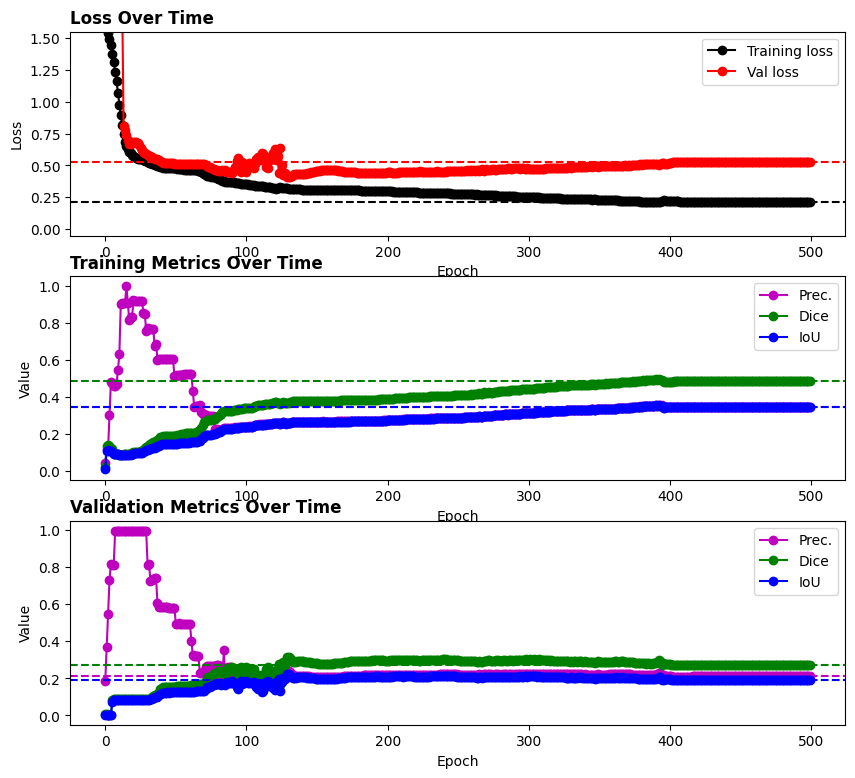

In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# train_loader, val_loader = get_synth_dataloaders(train_samp_size=50, val_samp_size=10, batch_size=5)
# model = UNet(2)

train_loader, val_loader = get_dataloaders(combined, segmented, train_samp_size=50, val_samp_size=20, batch_size=50)
model = UNetCh(1, 11)

optimizer = optim.Adam(model.parameters(), lr=0.01)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.005)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)


def overlap_metrics(pred, target, eps=1e-5):
    pred = F.sigmoid(pred)
    pred = (pred > 0.5).float()
    
    tp = (pred * target).sum(dim=(0, 2, 3))              # TP
    fp = (pred * (1 - target)).sum(dim=(0, 2, 3))         # FP
    fn = ((1 - pred) * target).sum(dim=(0, 2, 3))        # FN
    tn = ((1 - pred) * (1 - target)).sum(dim=(0, 2, 3))  # TN

    dice = (2*tp + eps) / (2*tp + fp + fn + eps)
    iou = (tp + eps) / (tp + fp + fn + eps)
    prec = (tp + eps) / (tp + fp + eps)
    # recall = (tp + eps) / (tp + fn + eps)
    # specificity = (tn + eps) / (tn + fp + eps)
    # pixel_acc = (tp + tn + eps) / (tp + tn + fp + fn + eps)

    return [dice.mean(), iou.mean(), prec.mean()]


def calc_loss(pred, target, bce_weight=0.5):
    def dice_loss(pred, target, smooth=1e-6):
        pred = F.sigmoid(pred)
        pred = (pred > 0.5).float()

        # pred = torch.softmax(pred, dim=1)
        # target_one_hot = nn.functional.one_hot(target, num_classes=num_classes).permute(0, 3, 1, 2).float()

        intersection = (pred * target).sum(dim=(0,2,3))
        union = pred.sum(dim=(0,2, 3)) + target.sum(dim=(0,2, 3))
        loss = 1. - 2.*((intersection + smooth) / (union + smooth))

        return loss.mean()
    
    def tversky_loss(pred, target, alpha=0.3, beta=0.7, smooth=1e-6):
        pred = F.sigmoid(pred)
        pred = (pred > 0.5).float()
        
        tp = (pred * target).sum(dim=(0, 2, 3))
        fp = (pred * (1 - target)).sum(dim=(0,2, 3))
        fn = ((1 - pred) * target).sum(dim=(0, 2, 3))

        tversky_loss = 1. - ((tp + smooth) / (tp + alpha*fp + beta*fn + smooth))

        return tversky_loss.mean()

    def iou_loss(pred, target, smooth=1.):
        pred = F.sigmoid(pred)
        pred = (pred > 0.5).float()

        intersection = (pred * target).sum(dim=(2,3))
        union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
        iou_loss = (1. - (intersection + smooth) / (union + smooth))
        return iou_loss.mean()
    

    # entropy_loss = F.binary_cross_entropy_with_logits(pred, target)
    criterion = nn.CrossEntropyLoss()
    entropy_loss = criterion(pred, target)
    overlap_loss = tversky_loss(pred, target)

    loss = (entropy_loss * bce_weight) + (overlap_loss * (1 - bce_weight))

    return loss


def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    train_loss = 0.

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        pred = model(X)
        train_batch_loss = loss_fn(pred, y)
        optimizer.zero_grad()
        train_batch_loss.backward()
        optimizer.step()

        train_loss += train_batch_loss.item()*X.size(0)

    train_loss /= len(dataloader)
    return train_loss 


def validation_loop(dataloader, model, loss_fn):
    model.eval()
    val_loss = 0.

    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)

        pred = model(X)
        val_batch_loss = loss_fn(pred, y)
        val_loss += val_batch_loss.item()*X.size(0)

    val_loss /= len(dataloader)
    return val_loss


def print_training_progress_bar(iteration, total,loss_val, length=30):
    percent = f"{100 * (float(iteration+1) / float(total)):.1f}"
    filled_length = int(length * (iteration+1) // (total))
    bar = '█' * filled_length + '-' * (length - filled_length)
    print(f'\rEpoch {iteration+1}/{total}| LR:{loss_val[-1]} | Train loss:{loss_val[0]:.4f} | Val loss:{loss_val[1]:.4f}: |{bar}| {percent}%', end = '\r')
    if iteration == total: 
        print()



def update_plot(trin_list, val_list):
    clear_output(wait=True)
    fig, ax = plt.subplots(nrows=3, figsize=(10,9))

    ax[0].plot(trin_list[0], label='Training loss', marker='o', color='k')
    ax[0].axhline(trin_list[0][-1], linestyle='--', color='k')
    ax[0].plot(val_list[0], label='Val loss', marker='o', color='r')
    ax[0].axhline(val_list[0][-1], linestyle='--', color='r')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss Over Time', loc='left', fontweight="bold")
    ax[0].set_ylim(-0.05, 1.55)
    ax[0].legend()

    ax[1].plot(trin_list[1]['Prec'], label='Prec.', marker='o', color='m')
    ax[1].axhline(trin_list[1]['Prec'][-1], linestyle='--', color='m')
    ax[1].plot(trin_list[1]['Dice'], label='Dice', marker='o', color='g')
    ax[1].axhline(trin_list[1]['Dice'][-1], linestyle='--', color='g')
    ax[1].plot(trin_list[1]['IoU'], label='IoU', marker='o', color='b')
    ax[1].axhline(trin_list[1]['IoU'][-1], linestyle='--', color='b')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Value')
    ax[1].set_title('Training Metrics Over Time', loc='left', fontweight="bold")
    ax[1].set_ylim(-0.05, 1.05)
    ax[1].legend()

    ax[2].plot(val_list[1]['Prec'], label='Prec.', marker='o', color='m')
    ax[2].axhline(val_list[1]['Prec'][-1], linestyle='--', color='m')
    ax[2].plot(val_list[1]['Dice'], label='Dice', marker='o', color='g')
    ax[2].axhline(val_list[1]['Dice'][-1], linestyle='--', color='g')
    ax[2].plot(val_list[1]['IoU'], label='IoU', marker='o', color='b')
    ax[2].axhline(val_list[1]['IoU'][-1], linestyle='--', color='b')
    ax[2].set_xlabel('Epoch')
    ax[2].set_ylabel('Value')
    ax[2].set_title('Validation Metrics Over Time', loc='left', fontweight="bold")
    ax[2].set_ylim(-0.05, 1.05)
    ax[2].legend()

    plt.show()



train_loss_list = []
val_loss_list = []

train_metrics = {'IoU':[],
                 'Dice':[],
                 'Prec':[]}
val_metrics = {'IoU':[],
               'Dice':[],
               'Prec':[]}

n_epoch = 500
for e in range(n_epoch):

    # train_loss = train_loop(train_loader, model, calc_loss, optimizer)
    # train_loss_list.append(train_loss)

    # val_loss = validation_loop(val_loader, model, calc_loss)
    # val_loss_list.append(val_loss)


    # train loop
    model.train()
    train_loss = 0.


    for train_input, train_target in train_loader:
        train_input, train_target = train_input.to(device), train_target.to(device)
        train_pred = model(train_input)
        train_pred = train_pred.to(device)
        train_batch_loss = calc_loss(train_pred, train_target)

        optimizer.zero_grad()
        train_batch_loss.backward()
        optimizer.step()
    
        train_loss += train_batch_loss.item()


    train_loss = train_loss / len(train_loader)
    train_loss_list.append(train_loss)
    train_om = overlap_metrics(pred=train_pred, target=train_target)
    train_metrics['Dice'].append(train_om[0].detach().numpy() / len(train_loader))
    train_metrics['IoU'].append(train_om[1].detach().numpy() / len(train_loader))
    train_metrics['Prec'].append(train_om[2].detach().numpy() / len(train_loader))

    scheduler.step(train_loss)


    # validation loop
    model.eval()
    val_loss = 0.

    for val_input, val_target in val_loader:
        val_input, val_target = val_input.to(device), val_target.to(device)

        val_pred = model(val_input)
        val_batch_loss = calc_loss(pred=val_pred, target=val_target)
        val_loss += val_batch_loss.item()

    val_loss /= len(val_loader)
    val_loss_list.append(val_loss)
    val_om = overlap_metrics(pred=val_pred, target=val_target)
    val_metrics['Dice'].append(val_om[0].detach().numpy() / len(val_loader))
    val_metrics['IoU'].append(val_om[1].detach().numpy() / len(val_loader))
    val_metrics['Prec'].append(val_om[2].detach().numpy() / len(val_loader))

    update_plot([train_loss_list, train_metrics], [val_loss_list, val_metrics])
    print_training_progress_bar(iteration=e, total=n_epoch, loss_val=[train_loss, val_loss, optimizer.param_groups[0]['lr']])


torch.save(model.state_dict(), '1208_mnist_unetch.pt')

### External training

In [ ]:
def calc_loss(pred, target, metrics, bce_weight=0.5, loss_type='dice'):
    # https://stats.stackexchange.com/questions/273537/f1-dice-score-vs-iou
    def dice_loss(pred, target, smooth=1.):
        pred = pred.contiguous()
        target = target.contiguous()

        intersection = (pred * target).sum(dim=2).sum(dim=2)
        dice_loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
        
        return dice_loss.mean()

    def iou_loss(pred, traget, smooth=1.):
        intersection = (target * pred).sum(dim=2).sum(dim=2)
        iou_loss = (1. - (intersection + smooth) / (target.sum(dim=2).sum(dim=2) + pred.sum(dim=2).sum(dim=2) - intersection + smooth))

        return iou_loss.mean()

    def overlap_metrics(pred, target, eps=1e-5):
        pred = pred.contiguous()
        target = target.contiguous()

        # metrics
        tp = torch.sum(pred * target)  # TP
        fp = torch.sum(pred * (1 - target))  # FP
        fn = torch.sum((1 - pred) * target)  # FN
        tn = torch.sum((1 - pred) * (1 - target))  # TN

        pixel_acc = (tp + tn + eps) / (tp + tn + fp + fn + eps)
        dice = (2 * tp + eps) / (2 * tp + fp + fn + eps)
        precision = (tp + eps) / (tp + fp + eps)
        recall = (tp + eps) / (tp + fn + eps)
        specificity = (tn + eps) / (tn + fp + eps)
        iou = (tp + eps) / (tp + fp + fp + eps)

        return [pixel_acc, dice, precision, recall, specificity, iou]
    
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = F.sigmoid(pred)

    if loss_type == 'dice':
        overlap_loss = dice_loss(pred, target)
    elif loss_type == 'iou':
        overlap_loss = iou_loss(pred, target)

    loss = bce * bce_weight + overlap_loss * (1 - bce_weight)

    o_m = overlap_metrics(pred, target)

    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['overlap_loss'] += overlap_loss.data.cpu().numpy() * target.size(0)
    metrics['Dice'] += o_m[1].data.cpu().numpy() * target.size(0)
    metrics['IOU'] += o_m[5].data.cpu().numpy() * target.size(0)
    metrics['prec'] += o_m[2].data.cpu().numpy() * target.size(0)

    return loss, metrics


def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
    print("{}: {}".format(phase, " | ".join(outputs)))


def train_model_externally(model, dat_load, optimizer, scheduler, num_epochs=50):
    dataloaders = dat_load
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    train_loss_list = []
    val_loss_list = []

    train_px_acc_list = []
    val_px_acc_list = []

    train_prec_list = []
    val_prec_list = []

    train_start_time = time.time()

    for epoch in range(num_epochs):
        print('=' * 10)
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['trn', 'val']:
            if phase == 'trn':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'trn'):
                    outputs = model(inputs)
                    loss, metrics = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'trn':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            if phase == 'trn':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
            
            if phase == 'trn':
                train_loss_list.append(metrics['loss'] / epoch_samples)
                train_px_acc_list.append(metrics['IOU'] / epoch_samples)
                train_prec_list.append(metrics['prec'] / epoch_samples)
            else:
                val_loss_list.append(metrics['loss'] / epoch_samples)
                val_px_acc_list.append(metrics['IOU'] / epoch_samples)
                val_prec_list.append(metrics['prec'] / epoch_samples)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
 
    total_time_elapsed = time.time() - train_start_time 
    print('Best val loss: {:4f}, total train time {:.0f}m {:.0f}s'.format(best_loss, total_time_elapsed // 60, time_elapsed % 60))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, [train_loss_list, val_loss_list, train_px_acc_list, val_px_acc_list, train_prec_list, val_prec_list]

In [ ]:
class TrainRun():
    def __init__(self, unet_model, dataloaders_dict,
                 n_epoch=5, n_class=10, n_test=2, loss_type='dice', loss_bce_weight=0.5, init_lr=1e-3):
        self.n_class = n_class
        self.n_epoch = n_epoch
        self.n_test = n_test

        self.loss_type = loss_type
        self.loss_bce_weight = loss_bce_weight
        self.init_lr = init_lr

        self.dataloaders_dict = dataloaders_dict

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = unet_model(self.n_class).to(self.device)

        self.optimizer = optim.Adam(filter(lambda p: p.requires_grad, self.model.parameters()), lr=self.init_lr)
        self.scheduler = lr_scheduler.StepLR(self.optimizer, step_size=50, gamma=0.1)


    @staticmethod
    def calc_loss(pred, target, metrics, bce_weight=0.5, loss_type='dice'):
        # https://stats.stackexchange.com/questions/273537/f1-dice-score-vs-iou
        def dice_loss(pred, target, smooth=1.):
            pred = pred.contiguous()
            target = target.contiguous()

            intersection = (pred * target).sum(dim=2).sum(dim=2)
            dice_loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
            
            return dice_loss.mean()

        def iou_loss(pred, traget, smooth=1.):
            intersection = (target * pred).sum(dim=2).sum(dim=2)
            iou_loss = (1. - (intersection + smooth) / (target.sum(dim=2).sum(dim=2) + pred.sum(dim=2).sum(dim=2) - intersection + smooth))

            return iou_loss.mean()

        def overlap_metrics(pred, target, eps=1e-5):
            pred = pred.contiguous()
            target = target.contiguous()

            # metrics
            tp = torch.sum(pred * target)  # TP
            fp = torch.sum(pred * (1 - target))  # FP
            fn = torch.sum((1 - pred) * target)  # FN
            tn = torch.sum((1 - pred) * (1 - target))  # TN

            pixel_acc = (tp + tn + eps) / (tp + tn + fp + fn + eps)
            dice = (2 * tp + eps) / (2 * tp + fp + fn + eps)
            precision = (tp + eps) / (tp + fp + eps)
            recall = (tp + eps) / (tp + fn + eps)
            specificity = (tn + eps) / (tn + fp + eps)
            iou = (tp + eps) / (tp + fp + fp + eps)

            return [pixel_acc, dice, precision, recall, specificity, iou]
        
        bce = F.binary_cross_entropy_with_logits(pred, target)

        pred = F.sigmoid(pred)

        if loss_type == 'dice':
            overlap_loss = dice_loss(pred, target)
        elif loss_type == 'iou':
            overlap_loss = iou_loss(pred, target)

        loss = bce * bce_weight + overlap_loss * (1 - bce_weight)

        o_m = overlap_metrics(pred, target)

        metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
        metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
        metrics['overlap_loss'] += overlap_loss.data.cpu().numpy() * target.size(0)
        metrics['Dice'] += o_m[1].data.cpu().numpy() * target.size(0)
        metrics['IOU'] += o_m[5].data.cpu().numpy() * target.size(0)
        metrics['prec'] += o_m[2].data.cpu().numpy() * target.size(0)
        # metrics['px_acc'] += o_m[0].data.cpu().numpy() * target.size(0)
        # metrics['recall'] += o_m[3].data.cpu().numpy() * target.size(0)
        # metrics['spec'] += o_m[4].data.cpu().numpy() * target.size(0)

        return loss, metrics


    @staticmethod
    def print_metrics(metrics, epoch_samples, phase):
        outputs = []
        for k in metrics.keys():
            outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        print("{}: {}".format(phase, " | ".join(outputs)))

    
    def train_model(self):
        self.best_model_wts = copy.deepcopy(self.model.state_dict())
        self.best_loss = 1e10

        self.train_loss_list = []
        self.val_loss_list = []

        self.train_px_acc_list = []
        self.val_px_acc_list = []

        self.train_prec_list = []
        self.val_prec_list = []

        train_start_time = time.time()

        for epoch in range(self.n_epoch):
            print('== Epoch {}/{} =='.format(epoch, self.n_epoch - 1))
            print('-' * 15)

            epoch_start_time = time.time()

            # Each epoch has a training and validation phase
            for phase in ['trn', 'val']:
                if phase == 'trn':
                    self.model.train()  # Set model to training mode
                else:
                    self.model.eval()  # Set model to evaluate mode

                metrics = defaultdict(float)
                epoch_samples = 0

                for inputs, labels in self.dataloaders_dict[phase]:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)

                    # zero the parameter gradients
                    self.optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'trn'):
                        outputs = self.model(inputs)
                        outputs = F.sigmoid(outputs)
                        loss, metrics = self.calc_loss(outputs, labels, metrics,
                                                       loss_type=self.loss_type,
                                                       bce_weight=self.loss_bce_weight)

                        # backward + optimize only if in training phase
                        if phase == 'trn':
                            loss.backward()
                            self.optimizer.step()

                    # statistics
                    epoch_samples += inputs.size(0)

                if phase == 'trn':
                    self.scheduler.step()
                    for param_group in self.optimizer.param_groups:
                        print("LR", param_group['lr'])
                
                if phase == 'trn':
                    self.train_loss_list.append(metrics['loss'] / epoch_samples)
                    self.train_px_acc_list.append(metrics['IOU'] / epoch_samples)
                    self.train_prec_list.append(metrics['prec'] / epoch_samples)
                else:
                    self.val_loss_list.append(metrics['loss'] / epoch_samples)
                    self.val_px_acc_list.append(metrics['IOU'] / epoch_samples)
                    self.val_prec_list.append(metrics['prec'] / epoch_samples)

                self.print_metrics(metrics, epoch_samples, phase)
                epoch_loss = metrics['loss'] / epoch_samples

                # deep copy the model
                if phase == 'val' and epoch_loss < self.best_loss:
                    print("saving best model")
                    best_loss = epoch_loss
                    self.best_model_wts = copy.deepcopy(self.model.state_dict())

            time_elapsed = time.time() - epoch_start_time
            print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
        total_time_elapsed = time.time() - train_start_time 
        print('Best val loss: {:4f}, total train time {:.0f}m {:.0f}s'.format(best_loss, total_time_elapsed // 60, time_elapsed % 60))

        # load best model weights
        self.model.load_state_dict(self.best_model_wts)


    def exexute_train(self):
        self.train_model()

        # metrics plot
        plt.figure(figsize=(10,4))
        plt.plot(self.train_loss_list, label='train loss',
                 marker='o', color='k')
        plt.plot(self.val_loss_list, label='val loss',
                 marker='o', linestyle='--', color='k')

        plt.plot(self.train_prec_list, label='train prec',
                 marker='v', color='b')
        plt.plot(self.val_prec_list, label='val prec',
                 marker='v', linestyle='--', color='b')
        
        plt.plot(self.train_px_acc_list, label='train IOU',
                 marker='v', color='g')
        plt.plot(self.val_px_acc_list, label='val IOU',
                 marker='v', linestyle='--', color='g')

        plt.xticks(range(len(self.train_loss_list)))
        plt.xlabel('epoch')
        plt.ylabel('value')
        plt.legend()
        plt.show


    def execute_external_train(self):
        self.model, self.metrics_list = train_model_externally(model=self.model,
                                                                dat_load=self.dataloaders_dict,
                                                                optimizer=self.optimizer,
                                                                scheduler=self.scheduler,
                                                                num_epochs=self.n_epoch)
        
        # metrics plot
        plt.figure(figsize=(10,4))
        plt.plot(self.metrics_list[0], label='train loss',
                 marker='o', color='k')
        plt.plot(self.metrics_list[1], label='val loss',
                 marker='o', linestyle='--', color='k')

        plt.plot(self.metrics_list[4], label='train prec',
                 marker='v', color='b')
        plt.plot(self.metrics_list[5], label='val prec',
                 marker='v', linestyle='--', color='b')
        
        plt.plot(self.metrics_list[2], label='train IOU',
                 marker='v', color='g')
        plt.plot(self.metrics_list[3], label='val IOU',
                 marker='v', linestyle='--', color='g')

        plt.xticks(range(len(self.train_loss_list)))
        plt.xlabel('epoch')
        plt.ylabel('value')
        plt.legend()
        plt.show

In [ ]:
# training_datadict = get_dataloaders(combined_data=combined, segmented_data=segmented,
#                                     train_samp_size=1000, val_samp_size=500, batch_size=5)

training_datadict = get_synth_dataloaders(train_samp_size=1000, val_samp_size=500, batch_size=5)

In [ ]:
training = TrainRun(unet_model=UNet, dataloaders_dict=training_datadict,
                    n_epoch=3, n_class=2, loss_type='iou', loss_bce_weight=0.75, init_lr=0.001)
training.execute_external_train()

# Testing

### Digits

In [46]:
demo_trans = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.5], std=[0.5])])

test_dataset = M2NISTData(combined=combined, segmented=segmented,
                          samp_size=5000, samp_type='trn', transform=demo_trans)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=5, shuffle=True)

test_inputs, test_labels = next(iter(test_dataloader))
print(test_labels.shape)

torch.Size([5, 11, 64, 64])


### Symbols

In [ ]:
trans = shapes_demo_trans = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0], std=[1])])

test_dataloader = DataLoader(dataset=ShapesData(samp_size=100, transform=trans), batch_size=5, shuffle=True)
test_inputs, test_labels = next(iter(test_dataloader))
print(test_inputs.shape)

(5, 11, 64, 64)


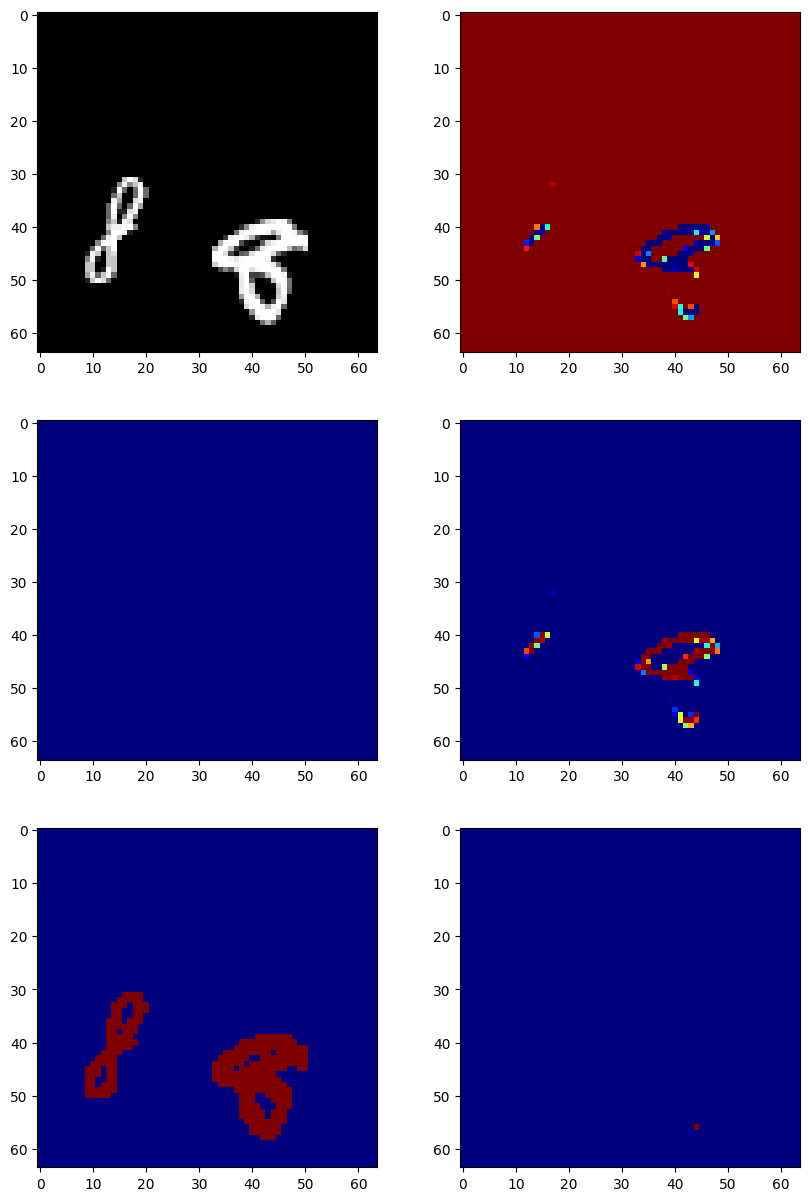

In [49]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_inputs = test_inputs.to(device)

model.eval()
test_pred = model(test_inputs)

# test_pred = F.relu6(test_pred)
test_pred = torch.softmax(test_pred, dim=1)
test_pred = test_pred.data.cpu().numpy()
print(test_pred.shape)


i = 3
one_lab, two_lab = 3, 8
 
fig, ax = plt.subplots(ncols=2,nrows=3, figsize=(10,15))
ax[0,0].imshow(test_inputs[i,0], cmap='Greys_r')
ax[0,1].imshow(test_pred[i,-1], cmap='jet', vmin=0)
ax[1,0].imshow(test_labels[i,one_lab], cmap='jet')
ax[2,0].imshow(test_labels[i,two_lab], cmap='jet')
ax[1,1].imshow(test_pred[i,one_lab], cmap='jet', vmin=0)
ax[2,1].imshow(test_pred[i,two_lab], cmap='jet', vmin=0)